# Xử lý dữ liệu với tập COLUMBIA

### 1. Thư viện cần thiết và nguồn dữ liệu.

In [ ]:
#Importing the necessary modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os 
import cv2
from tqdm import tqdm_notebook as tqdm 
import seaborn as sns
import joblib 
import warnings
import math
import pickle as pk
import datetime
import albumentations
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imageio import imread
import imageio
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers,Model,Sequential
from tensorflow.keras.layers import Dropout,Activation,InputLayer,LSTM,GRU,Bidirectional,TimeDistributed,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/LUAN-VAN/dataset/COLUMBIA/'

DATASET_PATHS = {
    'real': 'Au',
    'fake': 'Tp',
    'mask': 'Gt'
}

In [ ]:
dest_path = '/content/'
#mask_img = cv2.imread('canong3_canonxt_sub_01_edgemask.jpg')[:,:,:1]
mask_img = cv2.imread('canong3_canonxt_sub_01_edgemask.jpg')
mask_img= cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
#x, y, z =mask_img.shape
print(z)
#mask_img= cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(mask_img,(5,5),0) #Adding gaussian blur
ret,bin_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #modifing the values to either 0 or 255 
cv2.imwrite('1canong3_canonxt_sub_01_edgemask'+'.mask.png',mask_img)

3


True

In [ ]:

os.listdir(PATH+DATASET_PATHS['real'])[:10]

['6b03d2090daed654181fb1589bc6b808.png',
 '5f658c45fcaeae04ef3d3ba10bfa9103.png',
 '6a71ff741e480694f92a5c7f893f5ecc.png',
 '7a303fa7d3ed5b2f4bbe3f0772fd2247.png',
 '0d146cbc35b78a4dfa25cb404567ae41.png',
 '04d607a8124fa06ee737411f24444bcf.png',
 '1b28beae459b14fad0bdfcd4680952e6.png',
 '4db3702c70eaa3026b9692a6def7ab0c.png',
 '2a4df7ec33239ffbaf4f5b9a0b190ae3.png',
 '2d2109bc991437a2e9b0edb0efdd1434.png']

In [ ]:

os.listdir(PATH+DATASET_PATHS['fake'])[:10]

['95545cc4da4cae23ec42672bbbd3bfa7.mask.png',
 'c3faf90e9db3afcdafad8f283af02f2d.png',
 'bac7fb0f429c30179ca36411f11713ed.mask.png',
 'f0b605154f22ad7249c804668dcac3dd.mask.png',
 'd531b1cefbdd804a28399c46965aba52.png',
 'cf3eef59fe32392bef1dd5d18e79207b.mask.png',
 'c3cd547094fa52e65a22228bba5ef189.mask.png',
 'ac821291d07a9c317f2dbf5e424cb8cb.png',
 '1990a2ed067b8c537d8fe36d1ab4a7f2.png',
 'df2cf775afbb1d2880aa22f5f3c43995.png']

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

## 2. Exploratory Data Analysis 

In [ ]:
masked_dict  = {'name':[],'height':[], 'width':[], 'channels':[]} 
data_dict = {'name':[],'height':[], 'width':[], 'channels':[],'label':[]} 
#masked_df = pd.DataFrame(columns=['name', 'height', 'width','channels'])

In [ ]:
for path in DATASET_PATHS:
    for image in tqdm(os.listdir(PATH+DATASET_PATHS[path])):
        if image.split('_')[-1]=='edgemask.jpg':
            img = imread(PATH+DATASET_PATHS[path]+'/'+image)
            if len(img.shape)==2:
                height, width = img.shape   
                channels = 1
            else:
                height, width, channels = img.shape    
            masked_dict['name'].append(image)
            masked_dict['height'].append(height)
            masked_dict['width'].append(width)
            masked_dict['channels'].append(channels)
        else:
            try:
                img = imread(PATH+DATASET_PATHS[path]+'/'+image)
                if len(img.shape)==2:
                    height, width = img.shape   
                    channels = 1
                else:
                    height, width, channels = img.shape                
            except:
                pass
            data_dict['name'].append(image)
            data_dict['height'].append(height)
            data_dict['width'].append(width)
            data_dict['channels'].append(channels)
            data_dict['label'].append(DATASET_PATHS[path])

In [ ]:
data_df = pd.DataFrame.from_dict(data_dict)
masked_df = pd.DataFrame.from_dict(masked_dict)

In [ ]:
masked_df.head()

,name,height,width,channels
0,canong3_canonxt_sub_01_edgemask.jpg,568,757,3
1,canong3_canonxt_sub_02_edgemask.jpg,568,757,3
2,canong3_canonxt_sub_03_edgemask.jpg,568,757,3
3,canong3_canonxt_sub_05_edgemask.jpg,568,757,3
4,canong3_canonxt_sub_04_edgemask.jpg,568,757,3


In [ ]:
data_df.head()

,name,height,width,channels,label
0,47.tif,477,414,3,Au
1,56.tif,477,414,3,Au
2,14.tif,389,397,3,Au
3,27.tif,383,552,3,Au
4,94.tif,455,527,3,Au


In [ ]:
data_df.duplicated().any()

False

In [ ]:
masked_df.duplicated().any()

False

In [ ]:
os.makedirs('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA')

In [ ]:
masked_df.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/masked_df.csv',index=False)
data_df.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_df.csv',index=False)

In [ ]:
#masked_df.to_csv('masked_df.csv',index=False)
#data_df.to_csv('data_df.csv',index=False)
masked_df=pd.read_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COVERAGE/masked_df.csv')
data_df=pd.read_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COVERAGE/data_df.csv')

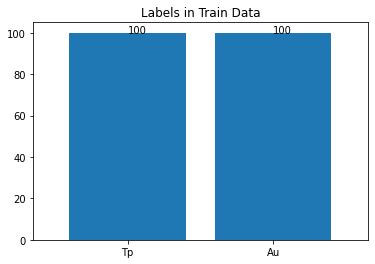

In [ ]:
lables= data_df['label'].value_counts()
ax=lables.plot.bar(width=.8,title='Labels in Train Data', rot=0)
for i, v in lables.reset_index().iterrows():
    ax.text(i, v.label, v.label)

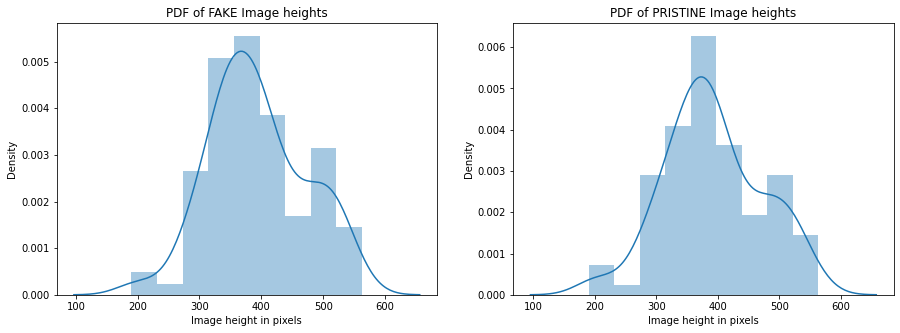

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('PDF of FAKE Image heights')
sns.distplot(data_df[data_df['label']=='Tp'].height,ax=ax[0])
ax[0].set_xlabel("Image height in pixels")
#sns.distplot(data_df[data_df['label']=='pristine'].height)
ax[0].set_xlabel("Image height in pixels")
sns.distplot(data_df[data_df['label']=='Au'].height,ax=ax[1])
#sns.distplot(data_df[data_df['label']=='pristine'].height)
ax[1].set_xlabel("Image height in pixels")
ax[1].set_title('PDF of PRISTINE Image heights')
plt.show()

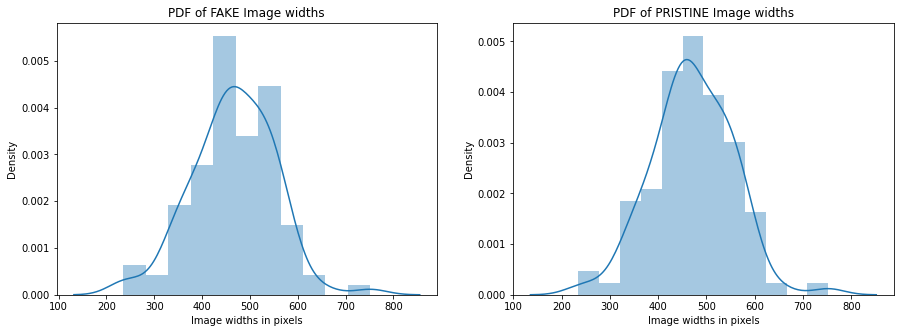

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('PDF of FAKE Image widths')
sns.distplot(data_df[data_df['label']=='Tp'].width,ax=ax[0])
ax[0].set_xlabel("Image widths in pixels")
ax[0].set_xlabel("Image widths in pixels")
sns.distplot(data_df[data_df['label']=='Au'].width,ax=ax[1])
ax[1].set_xlabel("Image widths in pixels")
ax[1].set_title('PDF of PRISTINE Image widths')
plt.show()

In [ ]:
# Now Checking the number of channels in images and masks

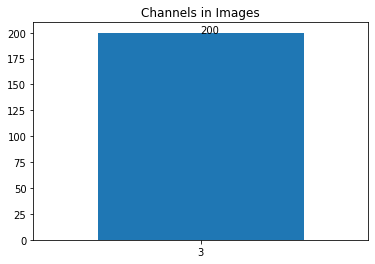

In [ ]:
lables= data_df['channels'].value_counts()
ax=lables.plot.bar(width=.8,title='Channels in Images', rot=0)
for i, v in lables.reset_index().iterrows():
    ax.text(i, v.channels, v.channels)

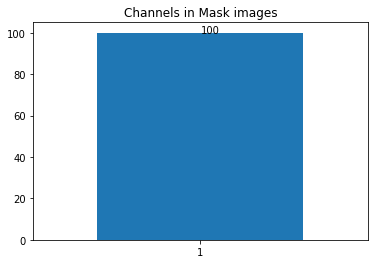

In [ ]:
lables= masked_df['channels'].value_counts()
ax=lables.plot.bar(width=.8,title='Channels in Mask images', rot=0)
for i, v in lables.reset_index().iterrows():
    ax.text(i, v.channels, v.channels)

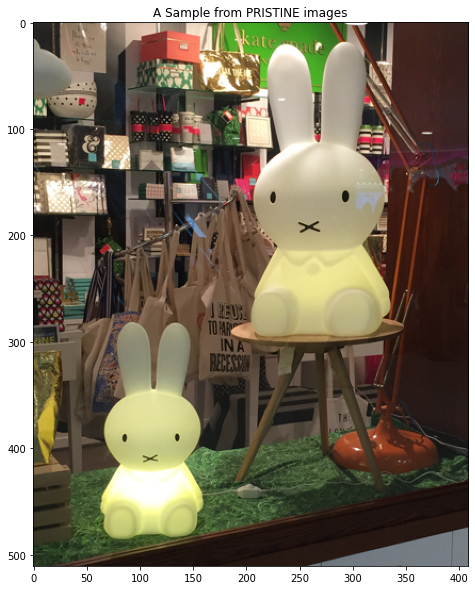

In [ ]:
plt.figure(figsize=(10,10))
image = imread(PATH+'image'+'/'+(data_df[data_df.label=='Au']['name']).iloc[20])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('A Sample from PRISTINE images')
plt.show()

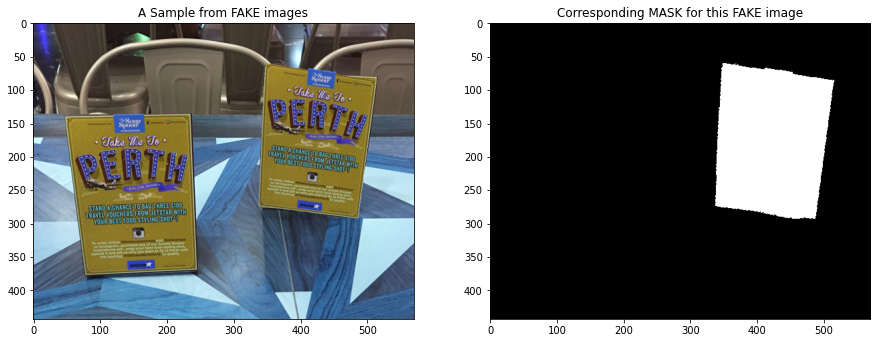

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
index = 15
image = cv2.imread(PATH+'image'+'/'+(data_df[data_df.label=='Tp']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(PATH+'mask'+'/'+(data_df[data_df.label=='Tp']['name']).iloc[index].split('t.')[0]+'forged.tif')
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
ax[0].imshow(image)
ax[1].imshow(mask_image)
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
plt.show()

In [ ]:
def change_brightness(img, beta):
    img_new = np.asarray(img + beta, dtype=int)   # cast pixel values to int
    img_new[img_new>100] = 100
    img_new[img_new<0] = 0
    return img_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


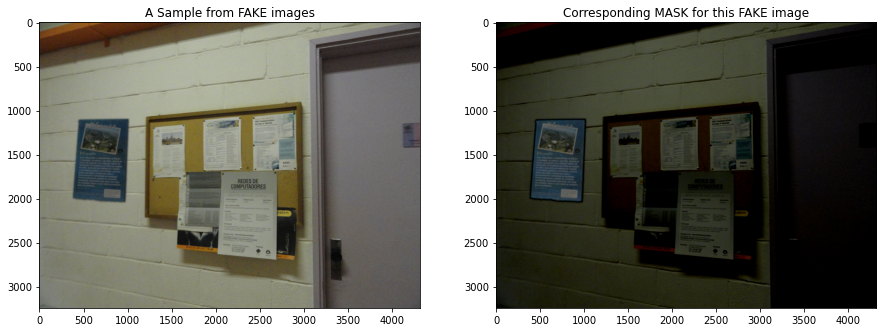

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
index = 4
image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask_image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
mask_image=change_brightness(mask_image,0)
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
#new_mask_image=change_brightness(mask_image, 1, 10)
ax[0].imshow(image)
ax[1].imshow((-mask_image + image),cmap='gray')
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
plt.show()

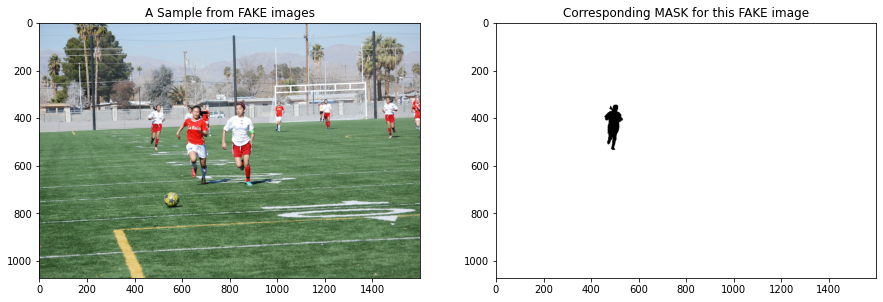

In [ ]:
index = 300
fig, ax = plt.subplots(1,2,figsize=(15,15))
image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
ax[0].imshow(image)
ax[1].imshow(mask_image,cmap='gray')
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
plt.show()

In [ ]:
data_df = pd.read_csv('data_df.csv')
masked_df = pd.read_csv('masked_df.csv')

In [ ]:
print("Total FAKE images in the data: {}".format(len(set(list(data_df[data_df.label=='Tp']['name'])))))
print("Total availble Masks for the data: {}".format(len(set(list(masked_df['name'])))))

Total FAKE images in the data: 100
Total availble Masks for the data: 100


In [ ]:

fake_names = list(set([i.split('_edgemask')[0] for i in list(masked_df['name'])]) & set([i.split('.')[0] for i in list(data_df[data_df.label=='Tp']['name'])]))

In [ ]:
print("Total intersection of Masks and FAKE images in the data: {}".format(len(fake_names)))

Total intersection of Masks and FAKE images in the data: 180


In [ ]:
delete_these = []
for image in fake_names:
    mask_img = cv2.imread(PATH+'Gt'+'/'+image+'_edgemask.jpg')
    fake_img = cv2.imread(PATH+'Tp'+'/'+image+'.tif')
    if mask_img.shape[:2]!= fake_img.shape[:2]:
        delete_these.append(image)
delete_these       

[]

In [ ]:
fake_names=list(set(fake_names)-set(delete_these))
print("Total valid masks are :{}".format(len(fake_names)))

Total valid masks are :180


In [ ]:
dest_path = PATH +'binary_masks/'
bin_masks =[]
for mask in tqdm(fake_names):
    mask_img = cv2.imread(PATH+'Gt'+'/'+mask+'_edgemask.jpg')
    mask_img= cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(mask_img,(5,5),0) #Adding gaussian blur
    ret,bin_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    cv2.imwrite(dest_path+mask+'.mask.png',bin_mask)
    bin_masks.append(bin_mask)

In [ ]:
def change_brightness(img, beta):
    img_new = np.asarray(img + beta, dtype=int)  
    img_new[img_new>90] = 90
    img_new[img_new<0] = 0
    return img_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


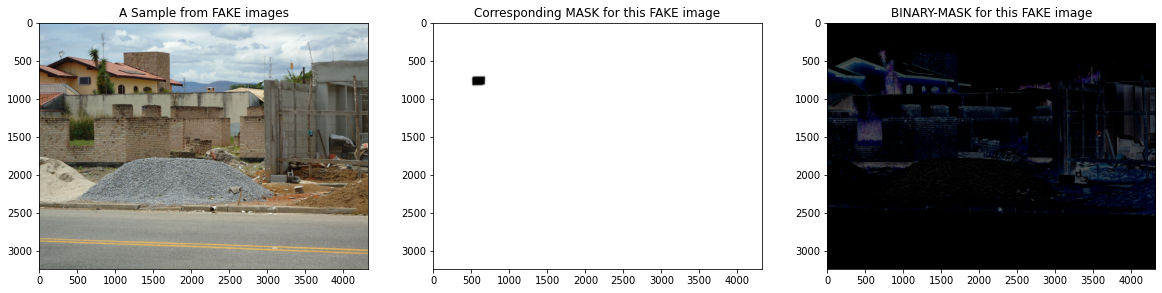

In [ ]:
index = 50
fig, ax = plt.subplots(1,3,figsize=(20,20))
image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask_image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
bin_mask = imread(PATH+'binary_masks/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
bin_mask = cv2.cvtColor(bin_mask, cv2.COLOR_GRAY2RGB)
new_bin_mask=change_brightness(bin_mask, 0)
ax[0].imshow(image)
ax[1].imshow(mask_image,cmap='gray')
ax[2].imshow(new_bin_mask-image)
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
ax[2].set_title('BINARY-MASK for this FAKE image')
plt.show()

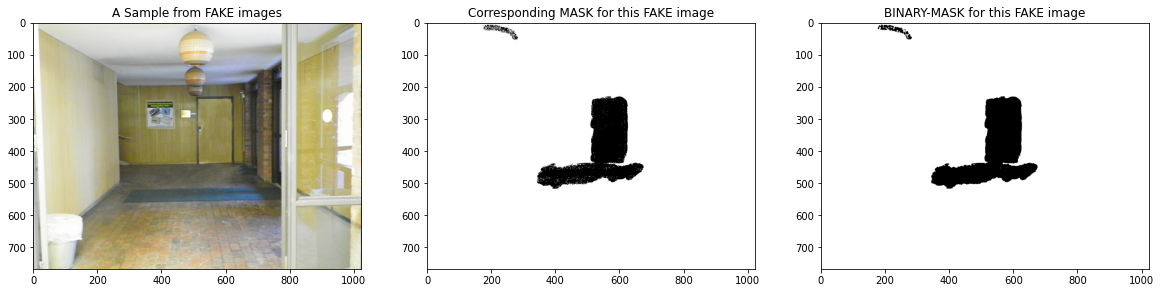

In [ ]:
index = 31
fig, ax = plt.subplots(1,3,figsize=(20,20))
image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
bin_mask = imread(PATH+'binary_masks/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
#bin_mask = cv2.cvtColor(bin_mask, cv2.COLOR_BGR2GRAY)
ax[0].imshow(image)
ax[1].imshow(mask_image,cmap='gray')
ax[2].imshow(bin_mask,cmap='gray')
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
ax[2].set_title('BINARY-MASK for this FAKE image')
plt.show()

In [ ]:
fake_names[:5]

['canong3_canonxt_sub_19',
 'nikond70_kodakdcs330_sub_06',
 'canong3_kodakdcs330_sub_04',
 'nikond70_kodakdcs330_sub_03',
 'canong3_nikond70_sub_06']

In [ ]:
fake_names_df = pd.DataFrame([i+'.tif' for i in fake_names],columns=['name'])
data_df_real = data_df[data_df.label == 'Au']
data_df_fake = data_df[data_df.label == 'Tp']

In [ ]:

data_df_fake = data_df_fake.join(fake_names_df.set_index('name'), on='name',how='right')

In [ ]:
data_df_final = pd.concat([data_df_real, data_df_fake], ignore_index=True)

In [ ]:
data_df_final.head()

,name,height,width,channels,label
0,kodakdcs330_01_sub_01.tif,625,747,3,Au
1,kodakdcs330_02_sub_01.tif,784,914,3,Au
2,kodakdcs330_03_sub_01.tif,773,947,3,Au
3,canong3_02_sub_02.tif,568,757,3,Au
4,canong3_02_sub_01.tif,568,757,3,Au


In [ ]:
index = 31
fig, ax = plt.subplots(1,3,figsize=(20,20))
image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = imread(PATH+'fake'+'/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
#mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
bin_mask = imread(PATH+'binary_masks/'+(data_df[data_df.label=='fake']['name']).iloc[index].split('.')[0]+'.mask.png')
#bin_mask = cv2.cvtColor(bin_mask, cv2.COLOR_BGR2GRAY)
ax[0].imshow(image)
ax[1].imshow(mask_image,cmap='gray')
ax[2].imshow(bin_mask,cmap='gray')
ax[0].set_title('A Sample from FAKE images')
ax[1].set_title('Corresponding MASK for this FAKE image')
ax[2].set_title('BINARY-MASK for this FAKE image')
plt.show()

In [ ]:

data_df_final.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_df_final.csv',index=False)

In [ ]:
data_df_final=pd.read_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COVERAGE/data_df_final.csv')

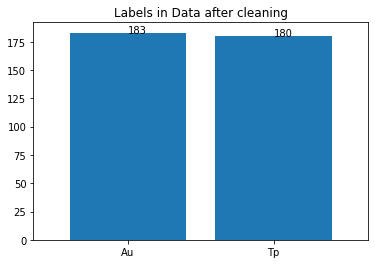

In [ ]:
lables= data_df_final['label'].value_counts()
ax=lables.plot.bar(width=.8,title='Labels in Data after cleaning', rot=0)
for i, v in lables.reset_index().iterrows():
    ax.text(i, v.label, v.label)

In [ ]:
data_df_final.head()

,name,height,width,channels,label
0,47.tif,477,414,3,Au
1,56.tif,477,414,3,Au
2,14.tif,389,397,3,Au
3,27.tif,383,552,3,Au
4,94.tif,455,527,3,Au


## 3. Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df_final[['channels', 'height', 'name', 'width','label']],
                                                    data_df_final['label'], 
                                                    test_size=0.2, 
                                                    stratify=data_df_final['label'],
                                                    random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train[['channels', 'height', 'name', 'width','label']],
                                                  y_train, test_size=0.2, stratify=y_train,random_state=42)

In [ ]:
print("........Data splits before the Agumentation...........")
print("Images in Train data before sampling: {} ".format(X_train.shape[0]))
print("Images in Test data  before sampling: {} ".format(X_test.shape[0]))
print("Images in Validation data before sampling: {} ".format(X_val.shape[0]))

........Data splits before the Agumentation...........
Images in Train data before sampling: 954 
Images in Test data  before sampling: 299 
Images in Validation data before sampling: 239 


In [ ]:
X_train.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/X_train.csv',index=False)
X_test.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/X_test.csv',index=False)
X_val.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/X_val.csv',index=False)

In [ ]:
X_train= pd.read_csv('X_train.csv')
X_test= pd.read_csv('X_test.csv')
X_val= pd.read_csv('X_val.csv')

In [ ]:
X_train.head()

,channels,height,name,width,label
304,3,768,1cd35a8e0f6a81c28b6e44179c445b01.png,1024,pristine
425,3,681,6d94adc79e810113317326ae83ea70fe.png,1024,pristine
194,3,768,3ebf544460233efb7f4250a4893a63aa.png,1024,pristine
292,3,768,4e0f423723345b694f34a9000ce7ea1a.png,1024,pristine
852,3,768,4ea40a7b40c7ebf754f900b56a3489db.png,1024,pristine


## 4. Data Agumentation

In [ ]:
#Ref: https://www.kaggle.com/alexanderliao/image-augmentation-demo-with-albumentation
#Ref : https://albumentations.readthedocs.io/en/latest/api/augmentations.html

from albumentations import (
PadIfNeeded,
HorizontalFlip,
VerticalFlip,
Transpose,
HueSaturationValue,
ElasticTransform,
GridDistortion,
OpticalDistortion,
RandomBrightnessContrast,
RandomGamma,Resize
)

In [ ]:


def agument(aug,image,mask):
    """This function will apply the type of augmentation on both image and mask
    returns augmented image and its augmented mask
    """
    augmented = aug(image=image, mask=mask)
    return augmented['image'],augmented['mask']


# All these below functions defines the different agumentations types.

def resize(image,mask): #While agumenting the data we are converting all images into the size of (512,512)
    aug = Resize(height=512,width=512,p=1)
    return agument(aug,image,mask)

def horizontalFlip(image,mask):
    aug = HorizontalFlip(p=1)
    return agument(aug,image,mask)
    
def verticalFlip(image,mask):
    aug = VerticalFlip(p=1)
    return agument(aug,image,mask)

def transpose(image,mask):
    aug = Transpose(p=1)
    return agument(aug,image,mask) 

def hueSaturationValue(image,mask):
    aug = HueSaturationValue(p=1,hue_shift_limit=100, sat_shift_limit=100, val_shift_limit=50)
    return agument(aug,image,mask)

def elasticTransform(image,mask):
    aug = ElasticTransform(p=1)
    return agument(aug,image,mask)

def opticalDistortion(image,mask):
    aug = OpticalDistortion(p=1, distort_limit=3, shift_limit=0.4)
    return agument(aug,image,mask)

def randomBrightnessContrast(image,mask):
    aug =RandomBrightnessContrast(p=1,brightness_limit=0.5, contrast_limit=0.4)
    return agument(aug,image,mask)

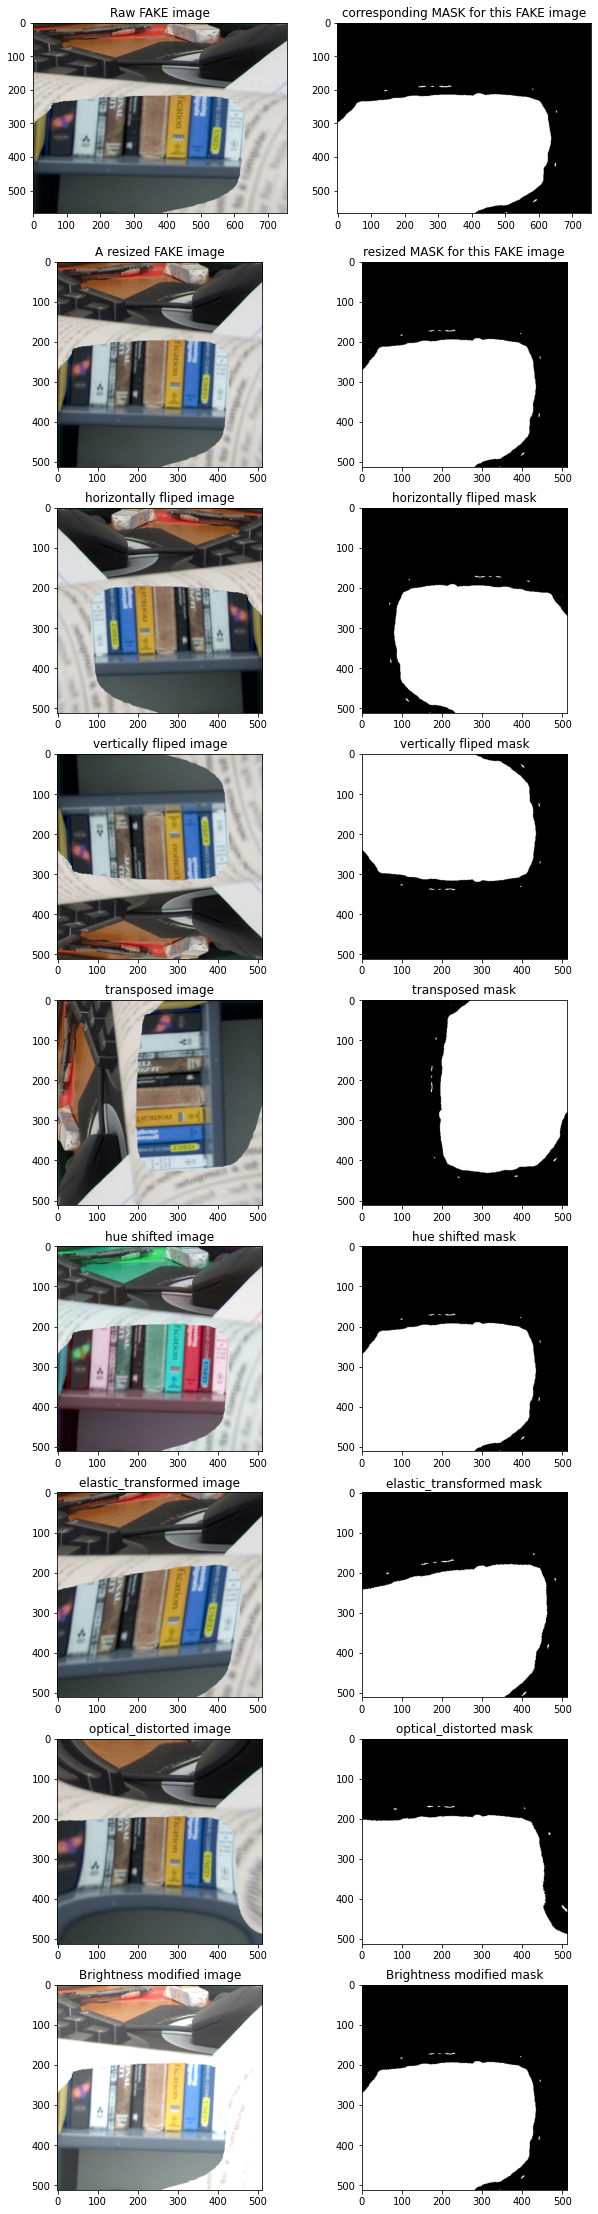

In [ ]:

index=60
fig, ax = plt.subplots(9,2,figsize=(10,40))
image_raw= imread(PATH+'Tp/'+data_df_final[data_df_final['label']=='Tp']['name'].iloc[index])
mask_raw = imread(PATH+'binary_masks/'+data_df_final[data_df_final['label']=='Tp']['name'].iloc[index].split('.')[0]+'.mask.png')

image,mask= resize(image=image_raw,mask=mask_raw)
image_h,mask_h= horizontalFlip(image=image,mask=mask)
image_v,mask_v= verticalFlip(image=image,mask=mask)
image_t,mask_t= transpose(image=image,mask=mask)
image_hue,mask_hue= hueSaturationValue(image=image,mask=mask)
image_elt,mask_elt= elasticTransform(image=image,mask=mask)
image_opt,mask_opt= opticalDistortion(image=image,mask=mask)
image_rbc,mask_rbc= randomBrightnessContrast(image=image,mask=mask)

ax[0][0].imshow(image_raw)
ax[0][1].imshow(mask_raw,cmap='gray')
ax[0][0].set_title('Raw FAKE image')
ax[0][1].set_title('corresponding MASK for this FAKE image')
ax[1][0].imshow(image)
ax[1][1].imshow(mask,cmap='gray')
ax[1][0].set_title('A resized FAKE image')
ax[1][1].set_title('resized MASK for this FAKE image')
ax[2][0].imshow(image_h)
ax[2][1].imshow(mask_h,cmap='gray')
ax[2][0].set_title('horizontally fliped image')
ax[2][1].set_title('horizontally fliped mask')
ax[3][0].imshow(image_v)
ax[3][1].imshow(mask_v,cmap='gray')
ax[3][0].set_title('vertically fliped image')
ax[3][1].set_title('vertically fliped mask')
ax[4][0].imshow(image_t)
ax[4][1].imshow(mask_t,cmap='gray')
ax[4][0].set_title('transposed image')
ax[4][1].set_title('transposed mask')
ax[5][0].imshow(image_hue)
ax[5][1].imshow(mask_hue,cmap='gray')
ax[5][0].set_title('hue shifted image')
ax[5][1].set_title('hue shifted mask')
ax[6][0].imshow(image_elt)
ax[6][1].imshow(mask_elt,cmap='gray')
ax[6][0].set_title('elastic_transformed image')
ax[6][1].set_title('elastic_transformed mask')
ax[7][0].imshow(image_opt)
ax[7][1].imshow(mask_opt,cmap='gray')
ax[7][0].set_title('optical_distorted image')
ax[7][1].set_title('optical_distorted mask')
ax[8][0].imshow(image_rbc)
ax[8][1].imshow(mask_rbc,cmap='gray')
ax[8][0].set_title('Brightness modified image')
ax[8][1].set_title('Brightness modified mask')
plt.show()

In [ ]:

test_path_fk = '/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/test/Tp/'


os.makedirs(test_path_fk)


In [ ]:
import tifffile

In [ ]:
def DataAgument(split_type,Type):
    """Function will accept the data in "split_type" and name of the split in "Type"
     From the data, it will take only FAKE images and its masks.
    for each fake image: 
        1. It will resizes the image and its mask
        2. And apply 6 kinds of agumentations
        3. Finally saves the agumented images and masks
    
    """
    for name in tqdm(split_type[split_type['label']=='Tp']['name']):
        name_path = PATH+'Tp/'+str(name)
        image_raw= cv2.imread(name_path)  
        mask_raw = imread(PATH+'binary_masks/'+name.split('.')[0]+'.mask.png')
        image_0,mask_0= resize(image=image_raw,mask=~mask_raw)
        cv2.imwrite('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/'+Type+'/Tp/'+name.split('.')[0]+'.png',image_0)
        cv2.imwrite('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/'+Type+'/Tp/'+name.split('.')[0]+'.mask.png',mask_0)


In [ ]:
DataAgument(split_type=data_df_final,Type="test")

In [ ]:

print("Total agumented FAKE images from TEST Split: {}".format(len(os.listdir(test_path_fk))/2))


Total agumented FAKE images from TEST Split: 100.0


In [ ]:

test_path_pr = '/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/test/Au/'

os.makedirs(test_path_pr)


In [ ]:
#Default white mask with same size as image size which is same for all pristine images
cv2.imwrite("/content/drive/MyDrive/LUAN-VAN/IFSM/Data/default.mask.png",np.zeros((512,512))+255)

True

In [ ]:
def DataAgument_pristine(split_type,Type):
    for name in tqdm(split_type[split_type['label']=='Au']['name']):
        name_path = PATH+'Au/'+str(name)
        image_raw= cv2.imread(name_path) 
        mask_raw= imread('/content/drive/MyDrive/LUAN-VAN/IFSM/default.mask.png') 
        image_0,mask_0= resize(image=image_raw,mask=mask_raw)

        cv2.imwrite('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/'+Type+'/Au/'+name.split('.')[0]+'.png',image_0)


In [ ]:

DataAgument_pristine(split_type=data_df_final,Type="test")


In [ ]:
print("Total agumented FAKE images from TRIAN Split: {}".format(len(os.listdir(train_path_fk))/2))
print("Total agumented FAKE images from TEST Split: {}".format(len(os.listdir(test_path_fk))/2))
print("Total agumented FAKE images from VALIDATION Split: {}".format(len(os.listdir(val_path_fk))/2))

Total agumented FAKE images from TRIAN Split: 2256.0
Total agumented FAKE images from TEST Split: 712.0
Total agumented FAKE images from VALIDATION Split: 568.0


In [ ]:
print("Total agumented Pristine images from TRIAN Split: {}".format(len(os.listdir(train_path_pr))))
print("Total agumented Pristine images from TEST Split: {}".format(len(os.listdir(test_path_pr))))
print("Total agumented Pristine images from VALIDATION Split: {}".format(len(os.listdir(val_path_pr))))

Total agumented Pristine images from TRIAN Split: 2016
Total agumented Pristine images from TEST Split: 630
Total agumented Pristine images from VALIDATION Split: 504


In [ ]:

test_path_fk = '/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/test/Tp/'

test_path_pr = '/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/test/Au/'


In [ ]:
train_data = pd.DataFrame()
X_label = []
y_label = []
for i in (list({i.split('.')[0] for i in os.listdir(train_path_fk)})):
    X_label.append(train_path_fk+i+'.png')
    y_label.append(train_path_fk+i+'.mask.png')
for i in (list({i.split('.')[0] for i in os.listdir(train_path_pr)})):
    X_label.append(train_path_pr+i+'.png')
    y_label.append('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/default.mask.png')    

train_data['X']  =  X_label 
train_data['y']  =  y_label 
train_data = shuffle(train_data)
train_data.reset_index(inplace=True, drop=True)
train_data.head()

,X,y
0,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...
1,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...
2,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...
3,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...
4,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...


In [ ]:
train_data.shape

(4272, 2)

In [ ]:
test_data = pd.DataFrame()
X_label = []
y_label = []
for i in (list({i.split('.')[0] for i in os.listdir(test_path_fk)})):
    X_label.append(test_path_fk+i+'.png')
    y_label.append(test_path_fk+i+'.mask.png')
for i in (list({i.split('.')[0] for i in os.listdir(test_path_pr)})):
    X_label.append(test_path_pr+i+'.png')
    y_label.append('/content/drive/MyDrive/LUAN-VAN/IFSM/default.mask.png')    

test_data['X']  =  X_label 
test_data['y']  =  y_label 
test_data = shuffle(test_data)
test_data.reset_index(inplace=True, drop=True)
test_data.head()

,X,y
0,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...,/content/drive/MyDrive/LUAN-VAN/IFSM/default.m...
1,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...
2,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...,/content/drive/MyDrive/LUAN-VAN/IFSM/default.m...
3,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...
4,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...,/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_D...


In [ ]:
test_data.shape

(363, 2)

In [ ]:
val_data = pd.DataFrame()
X_label = []
y_label = []
for i in (list({i.split('.')[0] for i in os.listdir(val_path_fk)})):
    X_label.append(val_path_fk+i+'.png')
    y_label.append(val_path_fk+i+'.mask.png')
for i in (list({i.split('.')[0] for i in os.listdir(val_path_pr)})):
    X_label.append(val_path_pr+i+'.png')
    y_label.append('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/default.mask.png')    

val_data['X']  =  X_label 
val_data['y']  =  y_label 
val_data = shuffle(val_data)
val_data.reset_index(inplace=True, drop=True)
val_data.head()

,X,y
0,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...
1,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...
2,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...
3,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/defa...
4,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...,/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data...


In [ ]:
#train_data.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data_agumented/train_data.csv',index="False")
test_data.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Testing_Data/COLUMBIA/data_agumented/test_data.csv',index="False")
#val_data.to_csv('/content/drive/MyDrive/LUAN-VAN/IFSM/Data/data_agumented/val_data.csv',index="False")